##Brian Kerlin
#HW 18:Try different minimization methods in scipy on larger systems ($N$ up to 20), and show 
- 1 the average number of attempts to find the ground state
- 2 the time costs


### Optional
try to improve the code to make it run faster, analyze the most time consuming part and give your solution


In [9]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
import requests
import time
import matplotlib.pyplot as plt
from numba import jit

@jit
def get_pos_from_url(address='http://doye.chem.ox.ac.uk/jon/structures/LJ/points/', N=7):
    url_address = address + str(N)
    data_str = requests.get(url_address).text
    return parse_url_text(data_str)    

@jit
def parse_url_text(data_str):
    x_array = []
    text = data_str.split('\n')
    for line in text:
        [x_array.append(float(i)) for i in line.split()]
    return np.array(x_array)

@jit
def dist(N_atoms):
    pos = get_pos_from_url(N = N_atoms)
    pos = np.reshape(pos,[N_atoms,3])
    #pos = 10*np.random.random(N_atoms*3)
    #pos = np.reshape(pos,[N_atoms,3])
    distance = cdist(pos,pos,'euclidean')
    iu1 = np.triu_indices(N_atoms)
    distance = distance[iu1]
    index = np.argwhere(distance==0)
    distance = np.delete(distance,index)
    return distance

@jit
def LJ(r):
    r6 = np.power(r,6)
    r12 = np.multiply(r6,r6)
    return 4*(1/r12 - 1/r6)

@jit
def Total_Energy(positions):

    E = LJ(positions)
    Energy = np.sum(E)
    return Energy

N_attempts = 50
f_values = []
x_values = []

@jit
def ground_state_potential(N_atom):
    pos = dist(N_atom)
    for i in range(N_attempts):
        
        res = minimize(Total_Energy, pos, method='CG', tol=1e-4)
        f_values.append(res.fun)
        x_values.append(res.x)
        #if i%10==0:
         #   print('step: ', i, '  values:', res.fun)

    print('The ground state potential is:  ', min(f_values))
    
#initial positions of atoms
@jit
def init_pos(N, L=5):
    '''
    N = # of atoms
    L = a sort of scaling factor for atoms to generate in a bigger area'''
    return L*np.random.random_sample((N*3,)) 

#finding the energy w/ optimization
@jit
def optim_energy(N, pos, resmethod, N_attempts=300):
    energy_val = []
    pos_val = []

    for i in range(N_attempts):
        res = minimize(Total_Energy, pos, method=resmethod, tol=1e-4)
        energy_val.append(res.fun)
        pos_val.append(res.x)
        print('\r Step: {:d} out of {:d}; values: {:.4f}'.format(i, N_attempts, res.fun), flush=True, end='')
    return energy_val, pos_val

<ipython-input-9-15509fbab6e0>:67: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function init_pos failed at nopython mode lowering due to: No definition for lowering np.random.random_sample(tuple(int64 x 1),) -> array(float64, 1d, C)

File "<ipython-input-9-15509fbab6e0>", line 72:
def init_pos(N, L=5):
    <source elided>
    L = a sort of scaling factor for atoms to generate in a bigger area'''
    return L*np.random.random_sample((N*3,)) 
    ^

[1] During: lowering "$0.9 = call $0.4($0.8, func=$0.4, args=[Var($0.8, <ipython-input-9-15509fbab6e0> (72))], kws=(), vararg=None)" at <ipython-input-9-15509fbab6e0> (72)
  @jit
C:\ProgramData\Anaconda\lib\site-packages\numba\compiler.py:742: NumbaWarning: Function "init_pos" was compiled in object mode without forceobj=True.

File "<ipython-input-9-15509fbab6e0>", line 68:
@jit
def init_pos(N, L=5):
^

  self.func_ir.loc))
C:\ProgramData\Anaconda\lib\site-packages\numba\compiler.py:751: NumbaDe

 Step: 299 out of 300; values: -20.8638

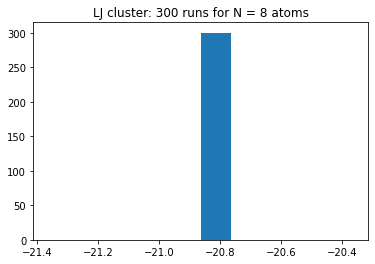

global minimum energy: -20.863791713949805   time: 31.398998975753784 sec


In [10]:
#N=8; ground state energy = -19.821489 eV

#pos_check = get_pos_from_url(N=8)
pos = init_pos(8)
N = 8
N_attempts = 300
time1 = time.time()
energy_val, pos_val = optim_energy(N, pos, resmethod='BFGS')
time2 = time.time()
dTime = time2 - time1

plt.title('LJ cluster: ' + str(N_attempts) + ' runs for N = ' + str(N) +' atoms')
plt.hist(energy_val)
plt.show()
print('global minimum energy:', min(energy_val), '  time:', dTime, 'sec')

 Step: 299 out of 300; values: -26.1175

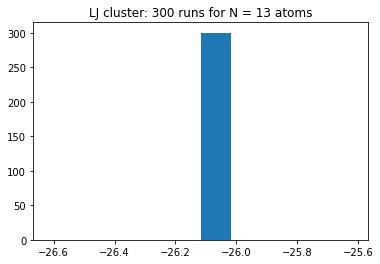

global minimum energy: -26.11751837646556   time: 36.795007944107056 sec


In [11]:
#N=13; ground state energy = -44.326801 eV

#pos_check = get_pos_from_url(N=13)
pos = init_pos(13)
N = 13
N_attempts = 300
time1 = time.time()
energy_val, pos_val = optim_energy(N, pos, resmethod='BFGS')
time2 = time.time()
dTime = time2 - time1

plt.title('LJ cluster: ' + str(N_attempts) + ' runs for N = ' + str(N) +' atoms')
plt.hist(energy_val)
plt.show()
print('global minimum energy:', min(energy_val), '  time:', dTime, 'sec')

#pos_check gives us -44.3268 eV @ 57.01 sec